# Analysis of CrowdFlower job #761593: sentence-level CID verification task with NER mistake choice for 200 development set abstracts

Tong Shu Li<br>
Created on Tuesday 2015-08-11<br>
Last updated 2015-08-11

A fourth choice, NER mistake, was added to the response form for the sentence-level CID verification task for BioCreative V. Here we analyze the results from this run.

Job Settings:

Parameter | Value
--- | ---
Job ID | #761593
Rows per page | 5
Judgements per row | 5
Payment per page | 10 cents USD
Payment per row | 2 cents USD
Contributor level | 2
Minimum time per page | 20 seconds
Minimum accuracy threshold | 70%
Number of test questions | 54
Date of launch | 11:36 am 2015-08-10
Date of finish | Job reached 85.9% completion at 11:30 am 2015-08-11 and was stopped
Total cost before bonuses | \$212.76 USD
Total cost after bonuses | $212.76 USD

---

In [1]:
from __future__ import division
from collections import Counter
from collections import defaultdict
from IPython.display import Image
import matplotlib as plt
import numpy as np
import os
import pandas as pd
import pickle

In [2]:
matplotlib inline

In [3]:
NUMPY_RAND_SEED = 993402

In [4]:
%%bash

rm src/get_AUC_value.pyc

In [5]:
from src.filter_data import filter_data
from src.data_model import parse_input
from src.data_model import Relation
from src.get_AUC_value import get_AUC_value
from src.F_score import *
from src.aggregate_results import *

---

### Read the gold standard:

In [6]:
def read_gold_standard(dataset, file_format = "list"):
    assert dataset in ["training", "development"]
    assert file_format in ["list", "dict"]
    
    fname = "data/{0}/parsed_{0}_set_{1}.pickle".format(dataset, file_format)
    
    if os.path.exists(fname):
        print "Reading cached version of {0} set ({1})".format(dataset, file_format)
        
        with open(fname, "rb") as fin:
            data = pickle.load(fin)
    else:
        print "Parsing raw {0} file".format(dataset)
        data = parse_input("data/{0}".format(dataset),
                           "CDR_{0}Set.txt".format(dataset.capitalize()),
                           return_format = file_format)
        
        with open(fname, "wb") as fout:
            pickle.dump(data, fout)
            
    return data

development_set = read_gold_standard("development", "dict")

Reading cached version of development set (dict)


In [7]:
def in_gold(row):
    pmid = int(row["pmid"])
    return int(development_set[pmid].has_relation(Relation(pmid, row["chemical_id"], row["disease_id"])))

### Read the results:

In [8]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_761593_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

raw_data = filter_data(settings)

In [9]:
raw_data.shape

(5564, 31)

In [10]:
raw_data["_tainted"].value_counts()

False    5500
True       64
dtype: int64

### Which workers were flagged?

In [11]:
def sample_worker_responses(job_id, worker_id, raw_data, category = None, sample_size = 10):
    """
    Randomly sample a worker's responses for review by hand.
    """
    test_resp = raw_data.query("_golden and _worker_id == {0}".format(worker_id))
    work_resp = raw_data.query("~_golden and _worker_id == {0}".format(worker_id))
    
    # a specific subcategory of responses
    if category is not None:
        work_resp = work_resp.query("verify_relationship == '{0}'".format(category))
        
    test_sample = test_resp
    work_sample = work_resp
    if len(test_resp) > sample_size:
        test_sample = test_resp.sample(sample_size, random_state = NUMPY_RAND_SEED)
        
    if len(work_resp) > sample_size:
        work_sample = work_resp.sample(sample_size, random_state = NUMPY_RAND_SEED)
    
    print "Worker id:", worker_id
    
    print "Test question sample:"
    for unit_id in test_sample["_unit_id"].unique():
        print "https://crowdflower.com/jobs/{0}/units/{1}".format(job_id, unit_id)

    print "Work question sample:"
    for unit_id in work_sample["_unit_id"].unique():
        print "https://crowdflower.com/jobs/{0}/units/{1}".format(job_id, unit_id)
        
    print "-----------------------------------------------------------------"

In [12]:
raw_data.query("_tainted")["_worker_id"].unique()

array([31641410, 31502056])

In [13]:
sample_worker_responses(761593, 31641410, raw_data, category = "ner_mistake")

Worker id: 31641410
Test question sample:
Work question sample:
https://crowdflower.com/jobs/761593/units/769153062
https://crowdflower.com/jobs/761593/units/769152754
https://crowdflower.com/jobs/761593/units/769152815
https://crowdflower.com/jobs/761593/units/769153206
https://crowdflower.com/jobs/761593/units/769152181
https://crowdflower.com/jobs/761593/units/769152487
https://crowdflower.com/jobs/761593/units/769152611
https://crowdflower.com/jobs/761593/units/769152489
https://crowdflower.com/jobs/761593/units/769152854
https://crowdflower.com/jobs/761593/units/769152735
-----------------------------------------------------------------


In [14]:
sample_worker_responses(761593, 31502056, raw_data, category = "yes_indirect")

Worker id: 31502056
Test question sample:
Work question sample:
https://crowdflower.com/jobs/761593/units/769153139
https://crowdflower.com/jobs/761593/units/769152749
https://crowdflower.com/jobs/761593/units/769152902
https://crowdflower.com/jobs/761593/units/769153150
https://crowdflower.com/jobs/761593/units/769152611
https://crowdflower.com/jobs/761593/units/769152636
https://crowdflower.com/jobs/761593/units/769152729
https://crowdflower.com/jobs/761593/units/769152701
https://crowdflower.com/jobs/761593/units/769152921
https://crowdflower.com/jobs/761593/units/769152734
-----------------------------------------------------------------


Worker 31641410 chose "ner_mistake" 70% of the time for the 20 work units he worked on. A sampling of the responses shows that the majority of them were not NER errors. For some work units, every other worker picked the same answer, and this worker was the only one who chose NER error. Therefore it was justified to remove this worker from the job because it doesn't seem like they were doing things properly.

The other worker had a higher trust score, but it also seems like their responses were not that great overall. Overall though I am not too concerned about flagging two workers.

### Remove judgements by tainted workers:

In [15]:
raw_data = raw_data.query("~_tainted")

In [16]:
raw_data.shape

(5500, 31)

### Comments:

In [17]:
raw_data["comment_box"].unique()

array([nan, 'NMS = neuroleptic malignant syndrome',
       'Talking about NMDA receptors.', 'MBC = metastatic breast cancer',
       'VPA was used to TREAT tonic-clonic convulsions.',
       'The glutamatergic dysfunction is a pre-existing condition causing the schizophrenia',
       "'Treatment' being the key word.",
       '**Resembling** alcoholic hepatitis, that extra word could make the fourth answer also right.',
       'If overdosed.',
       'RA together with BHA, makes the BHA-induced epithelial hyperplasia worse, \nwhich means that RA contributes to epithelial hyperplasia',
       'ammonium acetate increases muscular incoordination caused by diazepam, which means it directly contributes to it, while not causing it by itself.',
       "'Reversed' being the key term",
       "'Morphine analgesia' is a whole concept and not each of the juxtaposition of its parts",
       "'Advanced metastatic renal cell cancer' should be the whole term and if it wasn't the correct answer should 

In [18]:
comments = raw_data[~pd.isnull(raw_data["comment_box"])]

In [19]:
comments["_worker_id"].value_counts()

27555842    71
32984540     4
33803732     4
21477362     2
10086640     2
32518192     2
21807494     1
dtype: int64

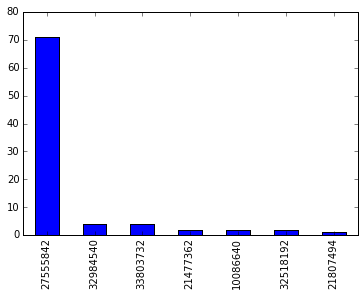

In [20]:
comments["_worker_id"].value_counts().plot(kind = "bar")

One worker made nearly all of the comments. This worker 27555842 first appeared in job 758438 and is apparently a medical student. For this job he originally only got 3/5 of the initial quiz correct, but I forgave one of his answers (a ner_mistake) and he since did very well.

There is useful information in the comments, but at the moment I will put them aside.

### Judgements per work unit

We stopped our job prematurely at 86% completion so that we could look at the data quickly. Therefore some work units did not receive the requested number of judgements (5). We filter out the work units which had low worker redundancy in order to reduce noise in our data.

In [21]:
work_votes = defaultdict(set)
for uniq_id, group in raw_data.groupby("uniq_id"):
    work_votes[len(group["_worker_id"].unique())].add(uniq_id)

In [22]:
for votes, units in work_votes.items():
    print "Judgements {0}, # of work units: {1}".format(votes, len(units))

Judgements 1, # of work units: 15
Judgements 2, # of work units: 11
Judgements 3, # of work units: 12
Judgements 4, # of work units: 57
Judgements 5, # of work units: 1035
Judgements 6, # of work units: 4


There are lots of work units for which there are fewer than 5 judgements. Some work units even have 0 judgements. These need to be filtered out for analysis.

It seems that crowdflower mistakenly asked some workers to work on units which were already completed. This is a bit odd, but not really a big deal. It's a very small percentage, so can be included in this analysis without problem.

In [23]:
#filter these out
units = list(work_votes[4] | work_votes[5] | work_votes[6])

raw_data = raw_data.query("uniq_id in {0}".format(units))

In [24]:
raw_data.shape

(5427, 31)

### Result aggregation (no choice mapping):

Before we convert any of the answer choices (such as "ner_mistake" to "no_relation"), we can take a look at the results at the original choice level.

In [25]:
res = aggregate_results("uniq_id", "verify_relationship", raw_data, "majority_vote", ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id"])

In [26]:
res

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id
0,bcv_easy_0,yes_indirect,2.5882,3,0.637676,15579441,769152007,D011692,D000860,15579441_D011692_D000860
1,bcv_easy_0,yes_direct,0.7353,1,0.181162,15579441,769152007,D011692,D000860,15579441_D011692_D000860
2,bcv_easy_0,no_relation,0.7353,1,0.181162,15579441,769152007,D011692,D000860,15579441_D011692_D000860
1,bcv_easy_1,ner_mistake,1.7647,2,0.431657,15579441,769152008,D011692,D000860,15579441_D011692_D000860
0,bcv_easy_1,yes_direct,1.5294,2,0.374101,15579441,769152008,D011692,D000860,15579441_D011692_D000860
2,bcv_easy_1,no_relation,0.7941,1,0.194242,15579441,769152008,D011692,D000860,15579441_D011692_D000860
2,bcv_easy_10,no_relation,2.3235,3,0.593987,18006530,769152017,D015742,D010146,18006530_D015742_D010146
0,bcv_easy_10,yes_direct,0.8529,1,0.218038,18006530,769152017,D015742,D010146,18006530_D015742_D010146
1,bcv_easy_10,ner_mistake,0.7353,1,0.187975,18006530,769152017,D015742,D010146,18006530_D015742_D010146
0,bcv_easy_100,no_relation,3.9327,5,1.000000,8766220,769152107,D017374,D059350,8766220_D017374_D059350


In [27]:
len(res["uniq_id"].unique())

1096

In [28]:
res.loc[:, "in_gold"] = res.loc[:, ["pmid", "chemical_id", "disease_id"]].apply(in_gold, axis = 1)

In [29]:
res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,in_gold
0,bcv_easy_0,yes_indirect,2.5882,3,0.637676,15579441,769152007,D011692,D000860,15579441_D011692_D000860,1
1,bcv_easy_0,yes_direct,0.7353,1,0.181162,15579441,769152007,D011692,D000860,15579441_D011692_D000860,1
2,bcv_easy_0,no_relation,0.7353,1,0.181162,15579441,769152007,D011692,D000860,15579441_D011692_D000860,1
1,bcv_easy_1,ner_mistake,1.7647,2,0.431657,15579441,769152008,D011692,D000860,15579441_D011692_D000860,1
0,bcv_easy_1,yes_direct,1.5294,2,0.374101,15579441,769152008,D011692,D000860,15579441_D011692_D000860,1


In [30]:
res.to_csv("data/befree/results/job_761593_raw_aggregate_results.tsv", sep = '\t', index = False)

### Any results where top answer is ner_error?

In [31]:
ner_top = set()
for uniq_id, group in res.groupby("uniq_id"):
    if group["verify_relationship"].iloc[0] == "ner_mistake":
        ner_top.add(uniq_id)
        
print "# of questions where NER error was the top choice: {0}".format(len(ner_top))
ner_top_data = res.query("uniq_id in {0}".format(list(ner_top)))

# of questions where NER error was the top choice: 57


In [32]:
ner_top_data

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,in_gold
1,bcv_easy_1,ner_mistake,1.7647,2,0.431657,15579441,769152008,D011692,D000860,15579441_D011692_D000860,1
0,bcv_easy_1,yes_direct,1.5294,2,0.374101,15579441,769152008,D011692,D000860,15579441_D011692_D000860,1
2,bcv_easy_1,no_relation,0.7941,1,0.194242,15579441,769152008,D011692,D000860,15579441_D011692_D000860,1
0,bcv_easy_1064,ner_mistake,3.1177,4,0.796999,15867025,769153071,D006514,D012409,15867025_D006514_D012409,0
1,bcv_easy_1064,no_relation,0.7941,1,0.203001,15867025,769153071,D006514,D012409,15867025_D006514_D012409,0
0,bcv_easy_1065,ner_mistake,3.2048,4,0.819495,15867025,769153072,D006514,D006509,15867025_D006514_D006509,1
1,bcv_easy_1065,no_relation,0.7059,1,0.180505,15867025,769153072,D006514,D006509,15867025_D006514_D006509,1
0,bcv_easy_1098,ner_mistake,2.2647,3,0.583340,15075188,769153105,D012964,D001201,15075188_D012964_D001201,0
1,bcv_easy_1098,no_relation,1.6176,2,0.416660,15075188,769153105,D012964,D001201,15075188_D012964_D001201,0
0,bcv_easy_1099,ner_mistake,2.4167,3,0.617025,15075188,769153106,D012964,D009404,15075188_D012964_D009404,0


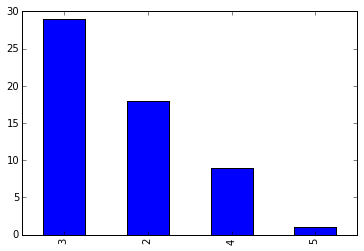

In [33]:
# how many votes did we get for ner_mistake when it was the top choice?
ner_top_data.query("verify_relationship == 'ner_mistake'")["num_votes"].value_counts().plot(kind = 'bar')

The NER error signal is not that strong. Very few questions had 5/5 ner_mistake votes. Overall I think the utility of the NER error choice is not too great, since BeFree is only using that information to determine whether the realtionship is true anyways.

For the final run and for the 3000 abstracts I think eliminating the NER choice will be just fine, and will decrease runtime. I am concerned about skewing the test question response distribution, but there's probably no way around that.

In [34]:
ner_top_data.to_csv("data/befree/results/job_761593_raw_aggregate_ner_error_units.tsv", sep = '\t', index = False)

### Aggregate and map votes:

Now we can aggregate and look at the results when we collapse the four original choices to a binary judgement about whether the relationship is true.

In [35]:
# take positive votes only, indirect is yes
res_positive_yes = aggregate_results("uniq_id", "verify_relationship", raw_data,
                                    "positive_signal_only",
                                     ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id"],
                                    "yes_direct", {"yes_indirect" : "yes_direct", "ner_mistake": "no_relation"})

In [36]:
# take positive votes only, indirect is yes
res_positive_no = aggregate_results("uniq_id", "verify_relationship", raw_data,
                                    "positive_signal_only",
                                     ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id"],
                                    "yes_direct", {"yes_indirect" : "no_relation", "ner_mistake": "no_relation"})

In [37]:
res_positive_yes["in_gold"] = res_positive_yes.loc[:, ["pmid", "chemical_id", "disease_id"]].apply(in_gold, axis = 1)

In [38]:
res_positive_no["in_gold"] = res_positive_no.loc[:, ["pmid", "chemical_id", "disease_id"]].apply(in_gold, axis = 1)

In [39]:
res_positive_yes.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,in_gold
0,bcv_easy_0,yes_direct,3.3235,4,0.818838,15579441,769152007,D011692,D000860,15579441_D011692_D000860,1
1,bcv_easy_0,no_relation,0.7353,1,0.181162,15579441,769152007,D011692,D000860,15579441_D011692_D000860,1
0,bcv_easy_1,yes_direct,1.5294,2,0.374101,15579441,769152008,D011692,D000860,15579441_D011692_D000860,1
1,bcv_easy_1,no_relation,2.5588,3,0.625899,15579441,769152008,D011692,D000860,15579441_D011692_D000860,1
0,bcv_easy_10,yes_direct,0.8529,1,0.218038,18006530,769152017,D015742,D010146,18006530_D015742_D010146,1


In [40]:
res_positive_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,in_gold
0,bcv_easy_0,yes_direct,0.7353,1,0.181162,15579441,769152007,D011692,D000860,15579441_D011692_D000860,1
1,bcv_easy_0,no_relation,3.3235,4,0.818838,15579441,769152007,D011692,D000860,15579441_D011692_D000860,1
0,bcv_easy_1,yes_direct,1.5294,2,0.374101,15579441,769152008,D011692,D000860,15579441_D011692_D000860,1
1,bcv_easy_1,no_relation,2.5588,3,0.625899,15579441,769152008,D011692,D000860,15579441_D011692_D000860,1
0,bcv_easy_10,yes_direct,0.8529,1,0.218038,18006530,769152017,D015742,D010146,18006530_D015742_D010146,1


In [41]:
res_positive_yes.to_csv("data/befree/results/job_761593_sentence_level_agg_indirect_is_yes.tsv", sep = '\t', index = False)

In [42]:
res_positive_no.to_csv("data/befree/results/job_761593_sentence_level_agg_indirect_is_no.tsv", sep = '\t', index = False)

### Select out only the positive signal from each individual work unit:

In [43]:
res_positive_yes = res_positive_yes.query("verify_relationship == 'yes_direct'")

In [44]:
res_positive_no = res_positive_no.query("verify_relationship == 'yes_direct'")

In [45]:
res_positive_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,in_gold
0,bcv_easy_0,yes_direct,0.7353,1,0.181162,15579441,769152007,D011692,D000860,15579441_D011692_D000860,1
0,bcv_easy_1,yes_direct,1.5294,2,0.374101,15579441,769152008,D011692,D000860,15579441_D011692_D000860,1
0,bcv_easy_10,yes_direct,0.8529,1,0.218038,18006530,769152017,D015742,D010146,18006530_D015742_D010146,1
0,bcv_easy_100,yes_direct,0.0000,0,0.000000,8766220,769152107,D017374,D059350,8766220_D017374_D059350,0
0,bcv_easy_1000,yes_direct,3.9446,5,1.000000,3952818,769153007,D005472,D066126,3952818_D005472_D066126,0


In [46]:
res_positive_no.shape

(1096, 11)

In [47]:
# number of unique chemical-disease pairs
len(res_positive_no["relation_pair_id"].unique())

749

We have more tasks than unique chemical_id-disease_id pairs, as anticipated. This again is a result of the fact that an abstract may have multiple cooccurrences of the same concept id pair.

### Interpretation:

<code>res_positive_yes</code> and <code>res_positive_no</code> represent what the crowd think about each relation pair at the individual sentence level. This is closest to how BeFree sees the data, since it works at the individual sentence level.

### Aggregate at the abstract level:

However for the BioCreative challenge we need to figure out whether the relation pair is true at the abstract level. Therefore we need to aggregate the results once more.

In [48]:
# test different aggregation schemes to see which one is best:
def aggregate_sentences(sentence_res):
    """
    Given the aggregated results at the individual work unit level,
    this function determines which sentence-bound drug-disease relationships
    are true at the abstract level.
    """
    res = defaultdict(list)
    for info, group in sentence_res.groupby(["pmid", "chemical_id", "disease_id"]):
        norm_conf_score_max = group["percent_agree"].max()
        norm_conf_score_min = group["percent_agree"].min()
        agree_median = group["percent_agree"].median()
        
        res["pmid"].append(info[0])
        res["chemical_id"].append(info[1])
        res["disease_id"].append(info[2])
        
        res["in_gold"].append(group["in_gold"].iloc[0])
        
        res["score_agree_max"].append(norm_conf_score_max)
        res["score_agree_min"].append(norm_conf_score_min)
        res["score_agree_median"].append(agree_median)
        
        res["score_vote_max"].append(group["num_votes"].max())
        res["score_vote_min"].append(group["num_votes"].min())
        res["score_vote_median"].append(group["num_votes"].median())
        
        res["score_agree_prod"].append(group["percent_agree"].prod())        
        
        res["uniq_ids"].append("|".join(group["uniq_id"].unique()))
        res["unit_ids"].append("|".join(map(lambda x: str(int(x)), group["unit_id"].unique())))
        
    return pd.DataFrame(res)

In [49]:
perf_yes = aggregate_sentences(res_positive_yes)

In [50]:
perf_no = aggregate_sentences(res_positive_no)

### Results for each unique concept id pair at the abstract level:

In [51]:
perf_yes

,chemical_id,disease_id,in_gold,pmid,score_agree_max,score_agree_median,score_agree_min,score_agree_prod,score_vote_max,score_vote_median,score_vote_min,uniq_ids,unit_ids
0,D011802,D056486,1,48362,0.586471,0.586471,0.586471,0.586471,3,3.0,3,bcv_easy_1155,769153162
1,C012282,D006528,0,85485,0.000000,0.000000,0.000000,0.000000,0,0.0,0,bcv_easy_382,769152389
2,C012282,D009369,0,85485,0.000000,0.000000,0.000000,0.000000,0,0.0,0,bcv_easy_381,769152388
3,D001556,D006528,1,85485,1.000000,1.000000,1.000000,1.000000,5,5.0,5,bcv_easy_378|bcv_easy_379,769152385|769152386
4,D001556,D017093,0,85485,0.807094,0.807094,0.807094,0.807094,4,4.0,4,bcv_easy_380,769152387
5,D003276,D008113,1,188339,1.000000,1.000000,1.000000,1.000000,5,5.0,5,bcv_easy_421|bcv_easy_424,769152428|769152431
6,D013256,D008113,0,188339,0.798508,0.798508,0.798508,0.798508,4,4.0,4,bcv_easy_423,769152430
7,D013999,D007008,0,326460,0.418119,0.209059,0.000000,0.000000,2,1.0,0,bcv_easy_393|bcv_easy_394,769152400|769152401
8,D004977,D009901,1,384871,1.000000,1.000000,1.000000,1.000000,5,5.0,5,bcv_easy_570,769152577
9,D004977,D064420,0,384871,1.000000,1.000000,1.000000,1.000000,5,5.0,5,bcv_easy_571,769152578


In [52]:
perf_no

,chemical_id,disease_id,in_gold,pmid,score_agree_max,score_agree_median,score_agree_min,score_agree_prod,score_vote_max,score_vote_median,score_vote_min,uniq_ids,unit_ids
0,D011802,D056486,1,48362,0.586471,0.586471,0.586471,0.586471,3,3.0,3,bcv_easy_1155,769153162
1,C012282,D006528,0,85485,0.000000,0.000000,0.000000,0.000000,0,0.0,0,bcv_easy_382,769152389
2,C012282,D009369,0,85485,0.000000,0.000000,0.000000,0.000000,0,0.0,0,bcv_easy_381,769152388
3,D001556,D006528,1,85485,1.000000,1.000000,1.000000,1.000000,5,5.0,5,bcv_easy_378|bcv_easy_379,769152385|769152386
4,D001556,D017093,0,85485,0.807094,0.807094,0.807094,0.807094,4,4.0,4,bcv_easy_380,769152387
5,D003276,D008113,1,188339,1.000000,1.000000,1.000000,1.000000,5,5.0,5,bcv_easy_421|bcv_easy_424,769152428|769152431
6,D013256,D008113,0,188339,0.798508,0.798508,0.798508,0.798508,4,4.0,4,bcv_easy_423,769152430
7,D013999,D007008,0,326460,0.418119,0.209059,0.000000,0.000000,2,1.0,0,bcv_easy_393|bcv_easy_394,769152400|769152401
8,D004977,D009901,1,384871,1.000000,1.000000,1.000000,1.000000,5,5.0,5,bcv_easy_570,769152577
9,D004977,D064420,0,384871,1.000000,1.000000,1.000000,1.000000,5,5.0,5,bcv_easy_571,769152578


### Which sentence aggregation metric works best?

In [53]:
# which aggregation method works best?
data = [perf_yes, perf_no]

temp = pd.DataFrame(columns = ["agg_type", "dataset", "precision", "recall", "F_score", "threshold"])

j = 0
for i, dataset in enumerate(data):
    for vote in ["agree", "vote"]:
        for mtype in ["max", "min", "median", "prod"]:
            if vote == "vote" and mtype == "prod":
                continue
                
            name = "score_{0}_{1}".format(vote, mtype)
            temp.loc[j] = max_F_score(name, "in_gold", dataset)
            temp.loc[j, "agg_type"] = name
            temp.loc[j, "dataset"] = "perf_yes" if i == 0 else "perf_no"
            j += 1

In [54]:
temp.sort("F_score", ascending = False)

,agg_type,dataset,precision,recall,F_score,threshold
7,score_agree_max,perf_no,0.565371,0.792079,0.659794,0.605632
0,score_agree_max,perf_yes,0.554054,0.811881,0.658635,0.605632
4,score_vote_max,perf_yes,0.561151,0.772277,0.650000,4.000000
11,score_vote_max,perf_no,0.574713,0.742574,0.647948,4.000000
9,score_agree_median,perf_no,0.570312,0.722772,0.637555,0.605632
2,score_agree_median,perf_yes,0.553506,0.742574,0.634249,0.604917
6,score_vote_median,perf_yes,0.569672,0.688119,0.623318,3.500000
13,score_vote_median,perf_no,0.519868,0.777228,0.623016,3.000000
1,score_agree_min,perf_yes,0.505415,0.693069,0.584551,0.583558
8,score_agree_min,perf_no,0.561644,0.608911,0.584323,0.605632


Again the trust based method seems to work best. The F-score is actually a lot lower than before, at 0.65. Precision is poor, but recall is ok when 3/5 people choose yes_direct. Performance is slightly worse when we use raw voting, and occurs at a higher threshold.

### Results using max score aggregation:

In [55]:
def aggregate_sentences_new(sentence_res):
    """
    Given the aggregated results at the individual work unit level,
    this function determines which sentence-bound drug-disease relationships
    are true at the abstract level.
    """
    res = defaultdict(list)
    for info, group in sentence_res.groupby(["pmid", "chemical_id", "disease_id"]):
        norm_conf_score_max = group["percent_agree"].max()
        
        res["pmid"].append(info[0])
        res["chemical_id"].append(info[1])
        res["disease_id"].append(info[2])
        
        res["in_gold"].append(group["in_gold"].iloc[0])
        
        res["score_vote_max"].append(group["num_votes"].max())
        res["conf_score"].append(norm_conf_score_max)
        
        res["uniq_ids"].append("|".join(group["uniq_id"].unique()))
        res["unit_ids"].append("|".join(map(lambda x: str(int(x)), group["unit_id"].unique())))
        
    return pd.DataFrame(res)

In [56]:
perf_yes_new = aggregate_sentences_new(res_positive_yes)

In [57]:
perf_no_new = aggregate_sentences_new(res_positive_no)

In [58]:
perf_yes_new.head()

,chemical_id,conf_score,disease_id,in_gold,pmid,score_vote_max,uniq_ids,unit_ids
0,D011802,0.586471,D056486,1,48362,3,bcv_easy_1155,769153162
1,C012282,0.000000,D006528,0,85485,0,bcv_easy_382,769152389
2,C012282,0.000000,D009369,0,85485,0,bcv_easy_381,769152388
3,D001556,1.000000,D006528,1,85485,5,bcv_easy_378|bcv_easy_379,769152385|769152386
4,D001556,0.807094,D017093,0,85485,4,bcv_easy_380,769152387


In [59]:
perf_no_new

,chemical_id,conf_score,disease_id,in_gold,pmid,score_vote_max,uniq_ids,unit_ids
0,D011802,0.586471,D056486,1,48362,3,bcv_easy_1155,769153162
1,C012282,0.000000,D006528,0,85485,0,bcv_easy_382,769152389
2,C012282,0.000000,D009369,0,85485,0,bcv_easy_381,769152388
3,D001556,1.000000,D006528,1,85485,5,bcv_easy_378|bcv_easy_379,769152385|769152386
4,D001556,0.807094,D017093,0,85485,4,bcv_easy_380,769152387
5,D003276,1.000000,D008113,1,188339,5,bcv_easy_421|bcv_easy_424,769152428|769152431
6,D013256,0.798508,D008113,0,188339,4,bcv_easy_423,769152430
7,D013999,0.418119,D007008,0,326460,2,bcv_easy_393|bcv_easy_394,769152400|769152401
8,D004977,1.000000,D009901,1,384871,5,bcv_easy_570,769152577
9,D004977,1.000000,D064420,0,384871,5,bcv_easy_571,769152578


In [60]:
perf_yes_new.to_csv("data/befree/results/job_761593_abstract_level_performance_indirect_is_yes.tsv", sep = '\t', index = False)

In [61]:
perf_no_new.to_csv("data/befree/results/job_761593_abstract_level_performance_indirect_is_no.tsv", sep = '\t', index = False)

### ROC analysis:

In [62]:
fname = "data/roc/job_761593_non_majority_metric_indirect_is_yes.png"
title = "ROC for job 761593 (sentence level) testing non-majority voting aggregation (indirect is yes); abstract-level results"
get_AUC_value(perf_yes_new, "conf_score", "in_gold", fname, title)

0.8077452169348565

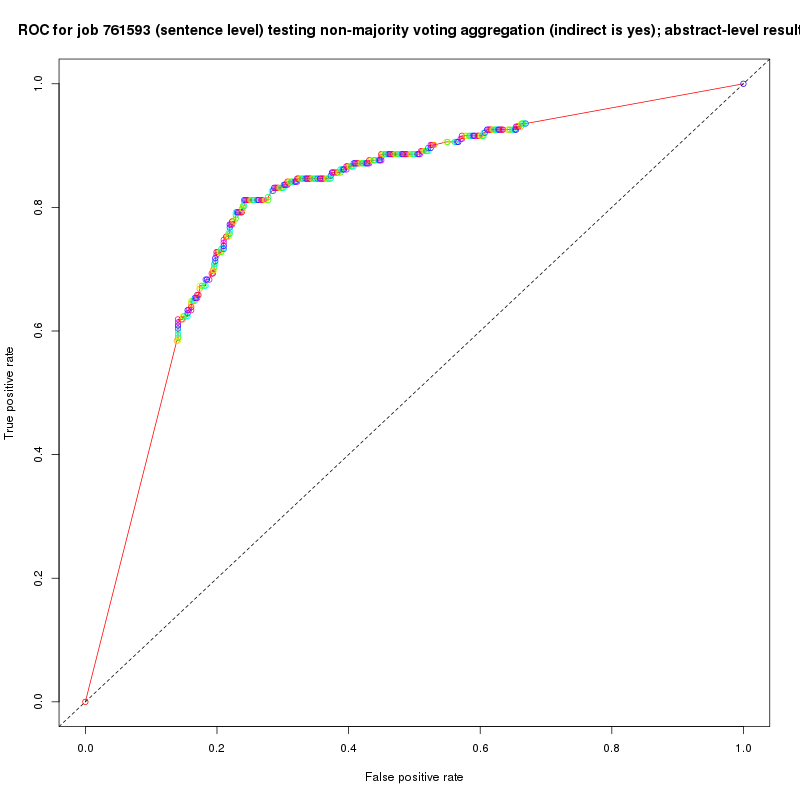

In [63]:
Image(fname)

In [64]:
fname = "data/roc/job_761593_non_majority_metric_indirect_is_no.png"
title = "ROC for job 761593 (sentence level) testing non-majority voting aggregation (indirect is no); abstract-level results"
get_AUC_value(perf_no_new, "conf_score", "in_gold", fname, title)

0.8092068347602581

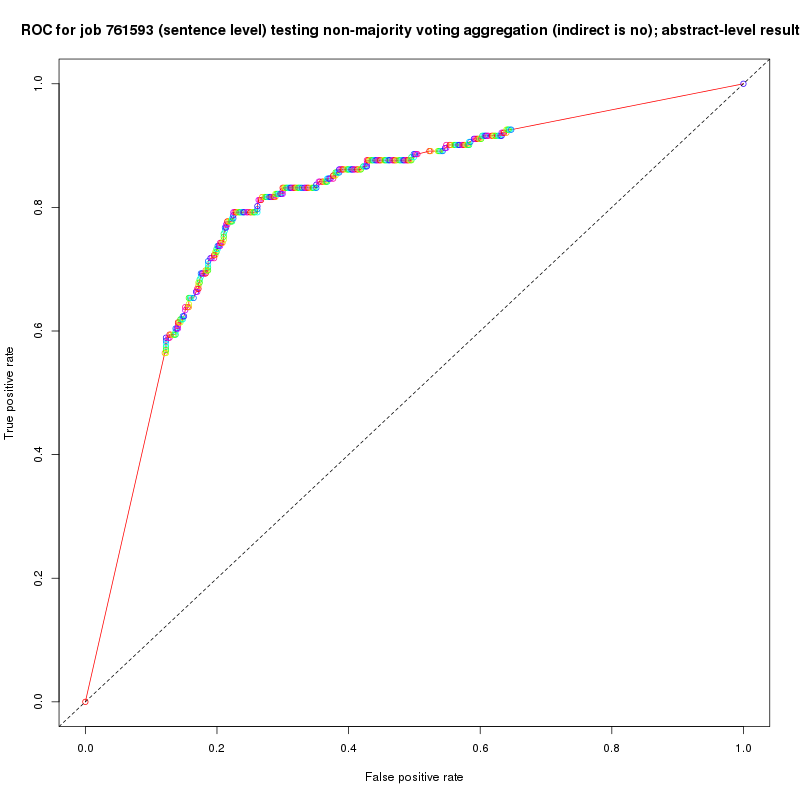

In [65]:
Image(fname)

In both cases, a positive label had a 80% chance to be higher rated by the crowd than a negative label. This isn't terribly bad, but let's also look at the F-score:

### F-score as a function of varying the voting threshold:

In [66]:
def plot_results(score_column, class_column, dataframe):
    res = all_F_scores(score_column, class_column, dataframe)
    res = res.sort("threshold")
    
    graph = res.plot(x = "threshold", figsize = (7, 7))
    graph.set_ylim((0, 1.1))

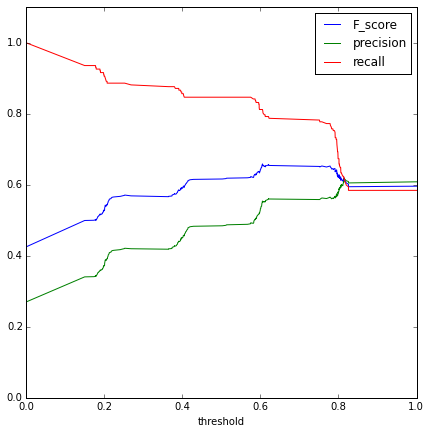

In [67]:
plot_results("conf_score", "in_gold", perf_yes_new)

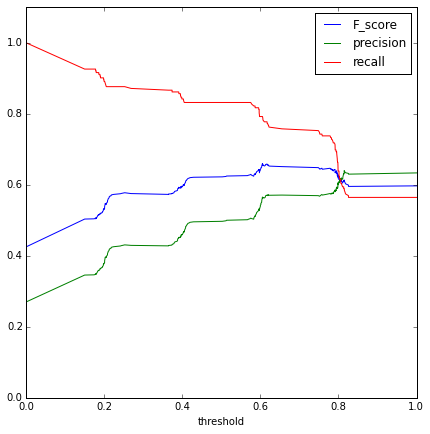

In [68]:
plot_results("conf_score", "in_gold", perf_no_new)

### Using raw number of votes only, ignoring the trust normalization:

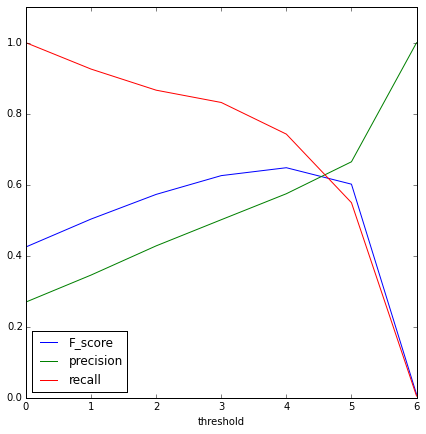

In [69]:
plot_results("score_vote_max", "in_gold", perf_no_new)

Performance is quite poor this time compared to previous times. In particular we get a F-score drop going from 4 to 5 workers. It seems likely that the cause for this is errors/ambiguities in the gold itself, or with how workers are interpreting my instructions resulting in high consensus but low agreement with the gold. There was only one work unit with 6 votes, so that is not statistically significant.

### Analysis of crowd disagreement with gold standard:

Can be split into two groups: when crowd says yes and gold says no, or vice versa.

In [70]:
true_pairs = perf_no_new.query("in_gold == 1")

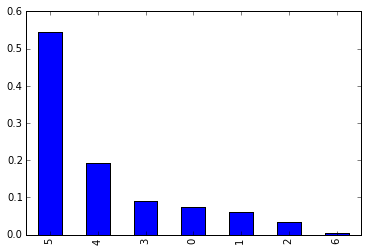

In [71]:
true_pairs["score_vote_max"].value_counts(normalize = True).plot(kind = "bar")

We see that when a relation is true, around 55% of the time the crowd also selects true with 100% agreement. These represent the trivial/simple relations where experts are likely to also be in consensus. For the 4/5 votes, this is also likely the case. The problem arises with the 0,1,2 votes cases. Let's look at those by hand.

PMID | Relation pair | Crowd response | Gold answer | Conclusion
--- | ---
18997632 | D002110-D002110 | no_relation 5/5 | 1 | Gold is just wrong here.. It says caffeine is used to improve seizure duration, which means it has a positive effect. The four other sentence-bound relations were all correctly matched.
15897593 | D003630-D006402 | no relation 5/5 | 1 | Not sure why gold says this is true. Crowd did well according to the task instructions.
15897593 | D064730-D006402 | yes_direct 5/5 | 0 | This and the previous question are completely flipped. It seems that people said yes for this one because dexrazoxane was in much closer proximity to hematologic toxicity. It almost seems like people did not read the "was investigated" part, and clicked yes right after they were done. Could use this as a test question or example I guess.
15867025 | D006514-D006509 | ner_error 4/5 | 1 | The gold is correct in that the surface antigens of Hepatitis B do in fact contribute to hepatitis B. However, the abstract for this paper discusses hospital compliance with vaccination standards. It does not say explicitly anywhere that the antigen causes hep B. This seems like a case of prior knowledge seeping into this paper, since only an expert would know that relation. I think the crowd did just fine here.
14975762 | D004317-D006333 | no_relation 4/5 | 1 | The paper states explicitly that doxorubicin causes myocardial apoptosis (heart cell death), and that overexpression of the p300 protein can counteract this effect. From a global perspective, it might make sense to say that if doxorubicin causes cardiac apoptosis, then it can cause heart failure. However, strictly speaking, the two are different concepts completely, and apoptosis does not necessarily equal heart failure. I think this result is again ok for the crowd, since the gold is being a little fuzzy.
12091028 | D007649-D006212 | no_relation 4/5 | 1 | The original abstract says that ketamine is used as an anaesthetic. It then says that ketamine is safe if taken together with dazepam. Finally, it implies that ketamine causes hallucinations by saying that diazepam reduces the severity of these hallucinations. I think this is not an error on the crowd's part, but rather that the task formulation has taken the sentence out of context and therefore the workers cannot make the correct choice. Hopefully these are infrequent..


Overall for the high consensus work units I think the crowd is doing just fine. Part of the errors comes from the faulty underlying assumption that a sentence is enough to make a decision regarding the relation, which is not the crowd's fault.

In [72]:
false_pairs = perf_no_new.query("in_gold == 0")

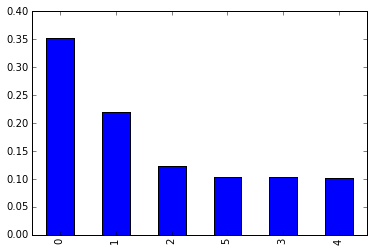

In [73]:
false_pairs["score_vote_max"].value_counts(normalize = True).plot(kind = "bar")

Here the votes on the x-axis is reversed. A value of 0 means all 5 of 5 workers chose "no_relation". We see that 5/5 and 4/5 no votes accounts for 55% of the total work units. There again are some 10% of work units where 5/5 of the crowd chose yes but the gold says the relation is invalid. Let's examine these:

In [74]:
temp = false_pairs.query("score_vote_max == 5")

In [75]:
temp

,chemical_id,conf_score,disease_id,in_gold,pmid,score_vote_max,uniq_ids,unit_ids
9,D004977,1,D064420,0,384871,5,bcv_easy_571,769152578
17,D007980,1,D004421,0,458486,5,bcv_easy_110,769152117
27,D003973,1,D014693,0,663266,5,bcv_easy_274,769152281
47,D004298,1,D002375,0,1687392,5,bcv_easy_855|bcv_easy_856|bcv_easy_859|bcv_eas...,769152862|769152863|769152866|769152873
71,D007069,1,D051437,0,2320800,5,bcv_easy_406,769152413
74,D015119,1,D013923,0,2339463,5,bcv_easy_212,769152219
77,C032151,1,D003866,0,2435991,5,bcv_easy_430,769152437
98,D013874,1,D012131,0,2893236,5,bcv_easy_442,769152449
101,C053571,1,D014693,0,2980315,5,bcv_easy_164|bcv_easy_167,769152171|769152174
113,D016685,1,D013921,0,3108839,5,bcv_easy_801|bcv_easy_807,769152808|769152814


In [76]:
temp.shape

(56, 8)

In [77]:
from itertools import chain

In [78]:
for unit_id in list(chain.from_iterable(temp["unit_ids"].map(lambda x: x.split('|')))):
    print "https://crowdflower.com/jobs/761593/units/{0}".format(unit_id)

https://crowdflower.com/jobs/761593/units/769152578
https://crowdflower.com/jobs/761593/units/769152117
https://crowdflower.com/jobs/761593/units/769152281
https://crowdflower.com/jobs/761593/units/769152862
https://crowdflower.com/jobs/761593/units/769152863
https://crowdflower.com/jobs/761593/units/769152866
https://crowdflower.com/jobs/761593/units/769152873
https://crowdflower.com/jobs/761593/units/769152413
https://crowdflower.com/jobs/761593/units/769152219
https://crowdflower.com/jobs/761593/units/769152437
https://crowdflower.com/jobs/761593/units/769152449
https://crowdflower.com/jobs/761593/units/769152171
https://crowdflower.com/jobs/761593/units/769152174
https://crowdflower.com/jobs/761593/units/769152808
https://crowdflower.com/jobs/761593/units/769152814
https://crowdflower.com/jobs/761593/units/769152354
https://crowdflower.com/jobs/761593/units/769152355
https://crowdflower.com/jobs/761593/units/769152364
https://crowdflower.com/jobs/761593/units/769153203
https://crow